#### 작업스케줄링 환경에서 모델을 학습시켜보는 코드입니다.
#### 자세한 사항은 docs/customEnv.md와 scheduler_env/customEnv.py를 참고해주세요

In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [2]:
from scheduler_env.customEnv import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

Resource x 8 , Order x 12 환경입니다
다른 환경에서 실험을 진행하고 싶다면 orders, resources 디렉토리를 참고해주세요

혹시 아래에서 오류가 발생할 경우 실행을 한 번 더 눌러주세요

In [16]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8-3.json", job_config_path = "instances/Jobs/v0-12-3-deadline.json")

아래는 랜덤으로 스케줄링을 진행한 것 입니다.
각 지표의 의미는 customEnv.py 파일을 참고해주세요

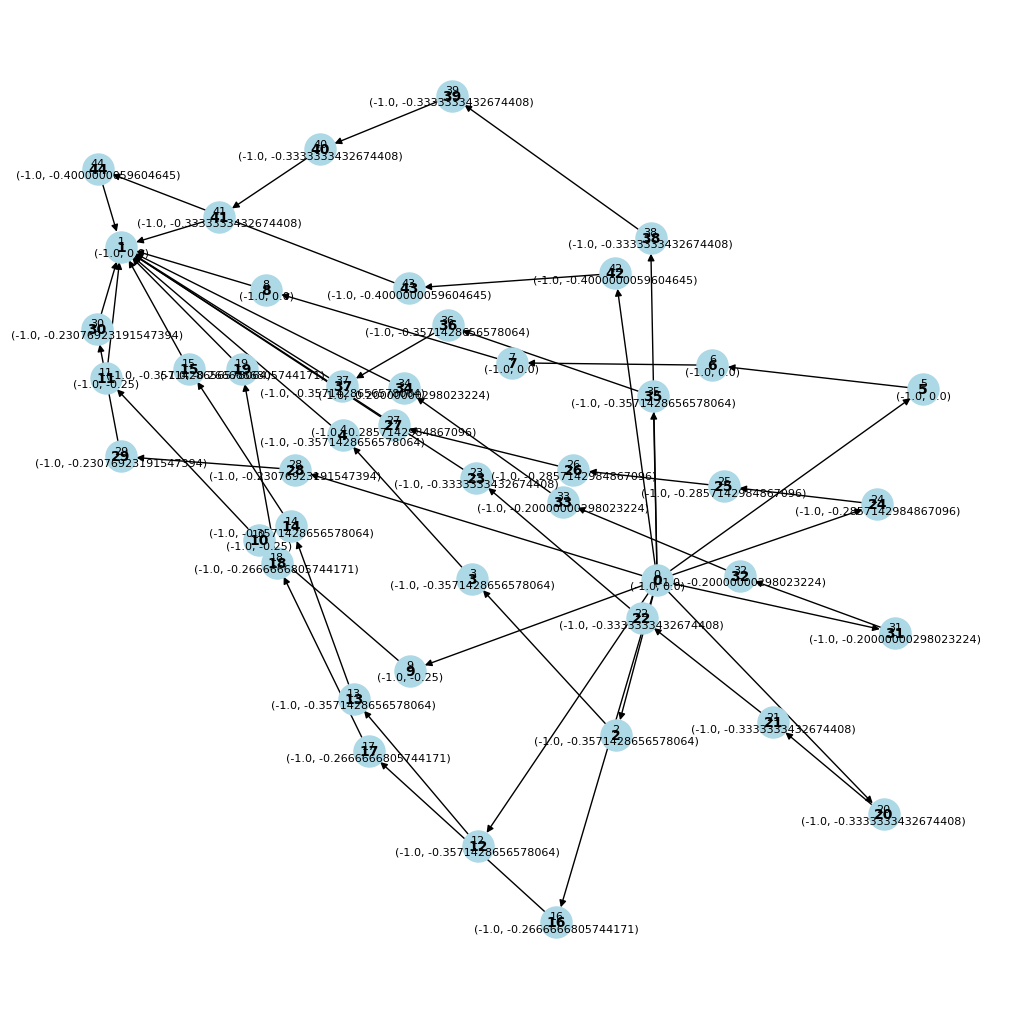

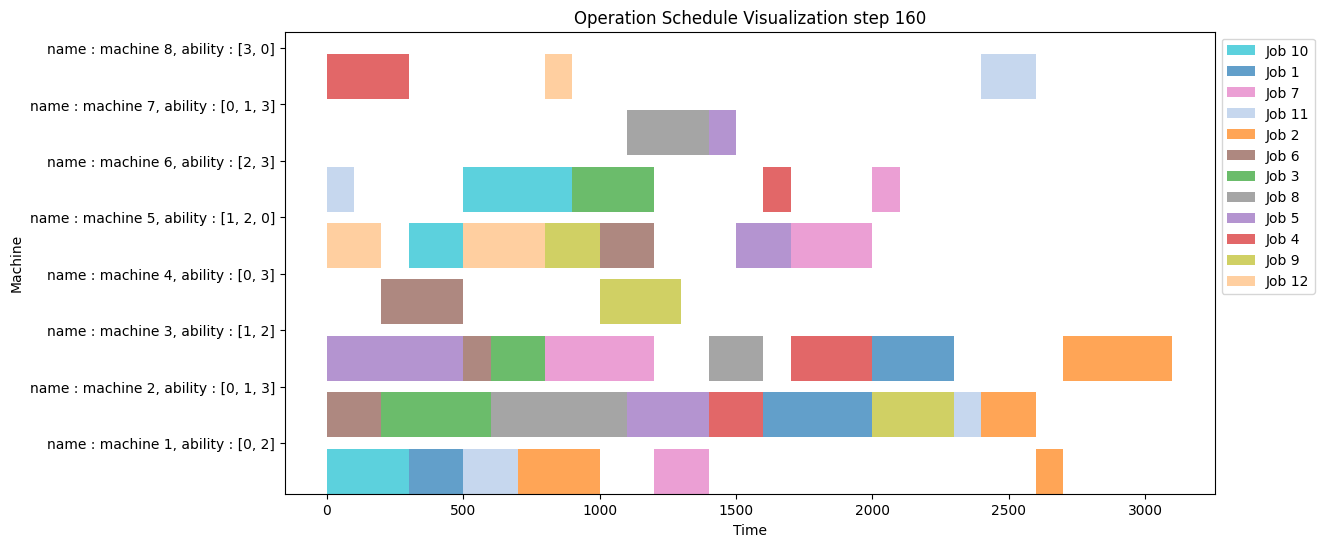

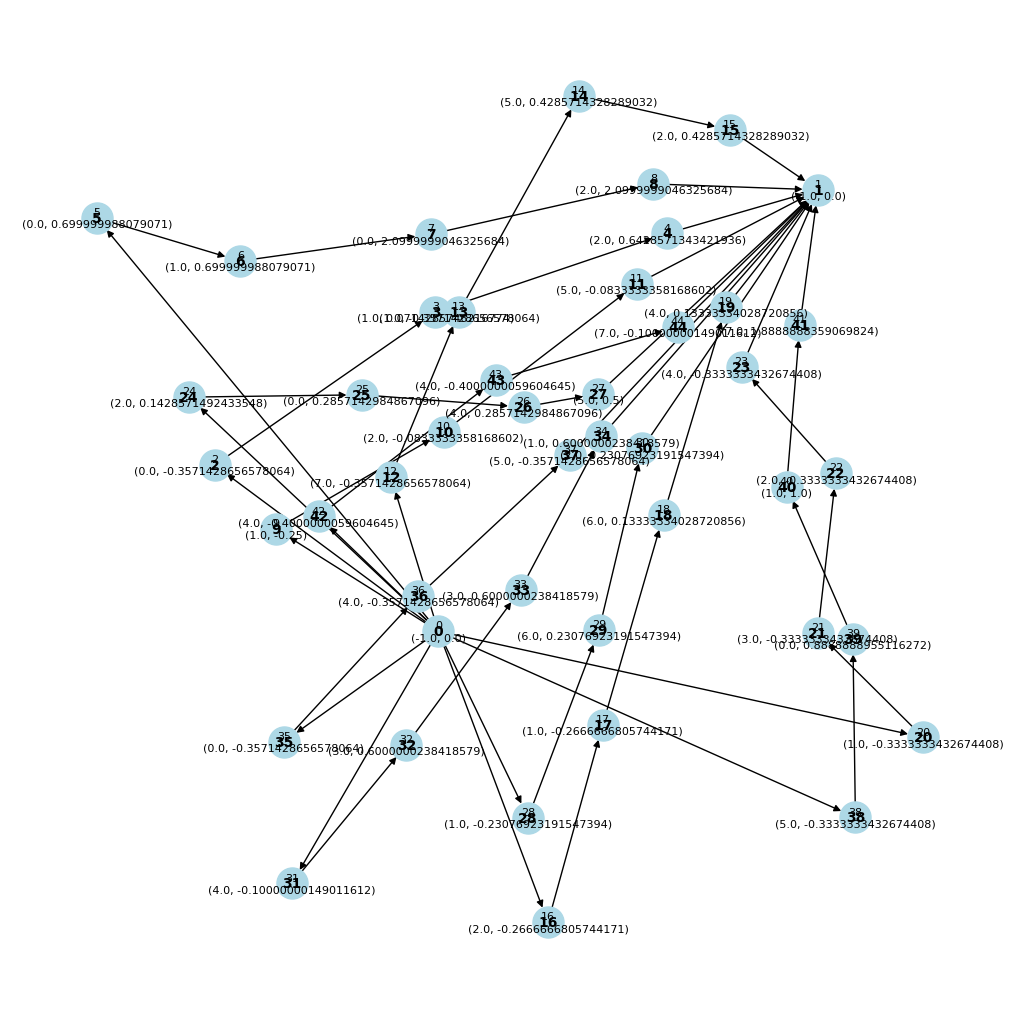

In [17]:
step = 0
obs, info = env.reset()
env.visualize_graph()
while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    
    if done:
        # print("Goal reached!", "final score=", reward)
        # print('finish_time', info['finish_time'])
        # print('job_density', info['job_density'])
        # print('machine_operation_rate', info['machine_operation_rate'])
        # print('job_deadline', info['job_deadline'])
        # print('job_time_exceeded', info['job_time_exceeded'])
        env.render()
        break

env.visualize_graph()

In [24]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-deadline.json", "instances/Jobs/v0-12-2-deadline.json", "instances/Jobs/v0-12-3-deadline.json"]
machine_paths = ["instances/Machines/v0-8.json", "instances/Machines/v0-8-2.json", "instances/Machines/v0-8-3.json"]

def make_env(job_path, machine_path):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path)
        return env
    return _init

envs = [make_env(job_path, machine_path) for job_path, machine_path in zip(job_paths, machine_paths)]

In [6]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomRewardCallback, self).__init__(verbose)
        self.env_rewards = []

    def _on_step(self) -> bool:
        # 각 환경별 리워드를 저장
        self.env_rewards.append(self.locals['rewards'])
        return True

    def _on_training_end(self) -> None:
        # 각 환경별로 리워드를 출력
        self.env_rewards = np.array(self.env_rewards)
        for env_idx in range(self.env_rewards.shape[1]):
            print(f"Environment {env_idx + 1} - Total Reward: {np.sum(self.env_rewards[:, env_idx])}")


PPO 모델을 해당 환경에서 1,000,000 step 만큼 학습시킵니다

In [25]:
from stable_baselines3.common.vec_env import SubprocVecEnv

vec_env = SubprocVecEnv(envs)

In [8]:
callback = CustomRewardCallback()

In [36]:
model = PPO('MultiInputPolicy', env, verbose=1).learn(2000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 152      |
|    ep_rew_mean     | -38      |
| time/              |          |
|    fps             | 1731     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | -38.7       |
| time/                   |             |
|    fps                  | 1368        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015054585 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss   

KeyboardInterrupt: 

Goal reached! final score= 32.0
finish_time 1600
job_density [0.6923076923076923, 0.7142857142857143, 0.9, 0.8181818181818182, 1.0, 0.6153846153846154, 0.8333333333333334, 1.0, 0.6666666666666666, 0.6428571428571429, 0.6, 1.0]
machine_operation_rate [0.875, 0.875, 0.8125, 0.75, 1.0, 0.8125, 0.875, 0.5625]
job_deadline [1400, 1000, 1200, 1400, 1500, 1200, 1400, 1300, 1000, 1400, 900, 1000]
job_time_exceeded [0, 400, 0, 200, 0, 100, 0, 0, 400, 0, 400, 100]


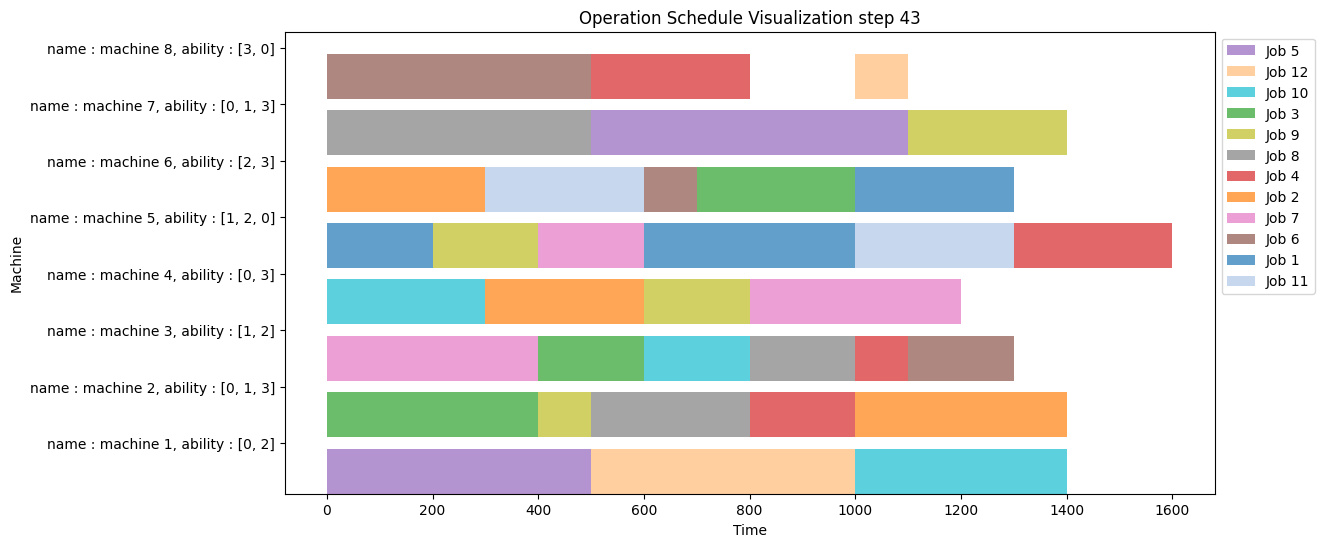

In [23]:
obs, info = env.reset()
done = False
while True:
    action, _ = model.predict(obs, deterministic = True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('job_density', info['job_density'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        env.render()
        break

In [27]:
custom_env = [SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-deadline.json"),
             SchedulingEnv(machine_config_path= "instances/Machines/v0-8-2.json", job_config_path = "instances/Jobs/v0-12-2-deadline.json"),
             SchedulingEnv(machine_config_path= "instances/Machines/v0-8-3.json", job_config_path = "instances/Jobs/v0-12-3-deadline.json")]

Goal reached! final score= 64.0
finish_time 1200
job_density [0.6666666666666666, 0.5, 0.7777777777777778, 0.6363636363636364, 0.5, 0.8571428571428571, 0.7, 1.0, 0.7142857142857143, 0.6666666666666666, 0.7, 0.7]
machine_operation_rate [0.8333333333333334, 1.0, 0.9166666666666666, 0.5, 0.9166666666666666, 0.8333333333333334, 1.0, 0.6666666666666666]
job_deadline [900, 900, 1050, 1050, 900, 900, 1050, 1500, 750, 900, 1050, 1050]
job_time_exceeded [0, 300, 0, 50, 300, 100, 0, 0, 350, 300, 50, 0]


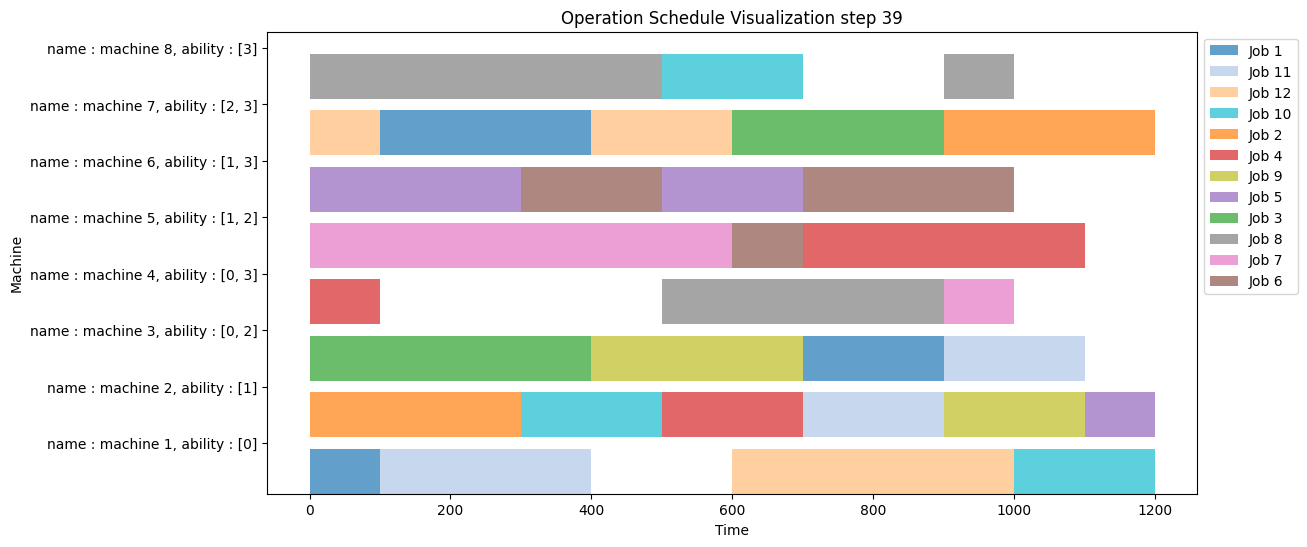

Goal reached! final score= 81.92063492063492
finish_time 1100
job_density [1.0, 0.6, 0.6, 0.8333333333333334, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.6666666666666666]
machine_operation_rate [1.0, 0.9090909090909091, 0.9090909090909091, 0.7272727272727273, 0.6363636363636364, 0.9090909090909091, 0.9090909090909091, 0.7272727272727273]
job_deadline [1200, 800, 1000, 900, 1200, 800, 1100, 1000, 700, 800, 700, 900]
job_time_exceeded [0, 200, 0, 100, 0, 0, 0, 0, 100, 0, 0, 0]


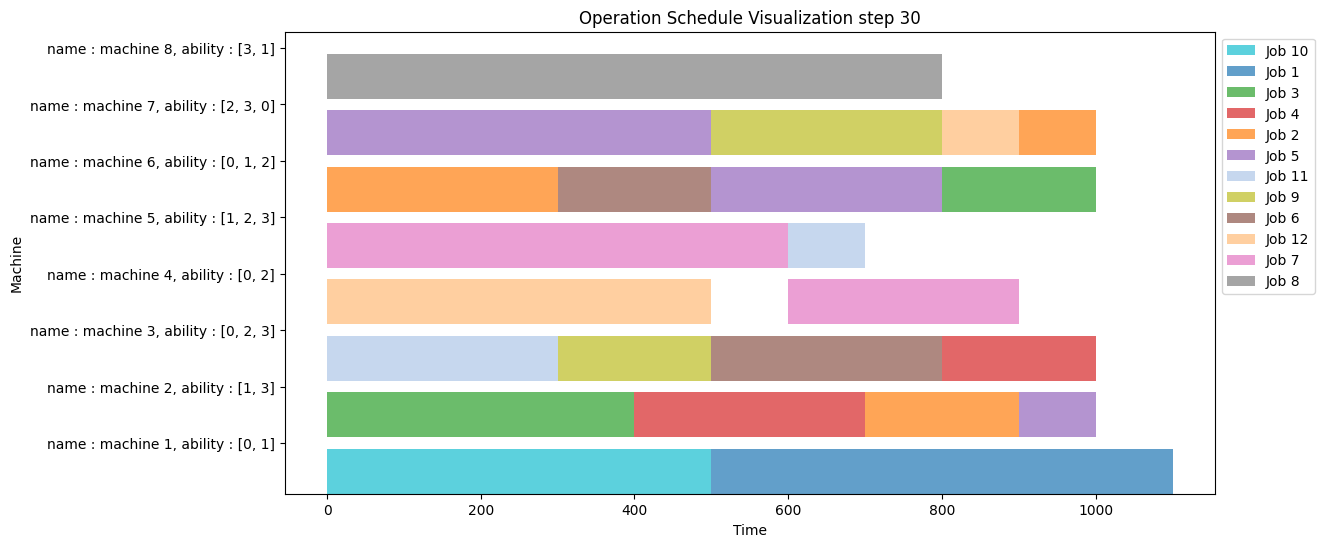

Goal reached! final score= 24.000000000000004
finish_time 1700
job_density [0.5294117647058824, 0.8333333333333334, 1.0, 0.9, 0.7857142857142857, 1.0, 0.7692307692307693, 0.9090909090909091, 0.7272727272727273, 0.6, 0.6666666666666666, 1.0]
machine_operation_rate [0.8823529411764706, 0.7647058823529411, 1.0, 0.5294117647058824, 0.8823529411764706, 0.6470588235294118, 0.7058823529411765, 0.7647058823529411]
job_deadline [1400, 1000, 1200, 1400, 1500, 1200, 1400, 1300, 1000, 1400, 900, 1000]
job_time_exceeded [300, 200, 0, 0, 200, 100, 0, 0, 400, 100, 600, 200]


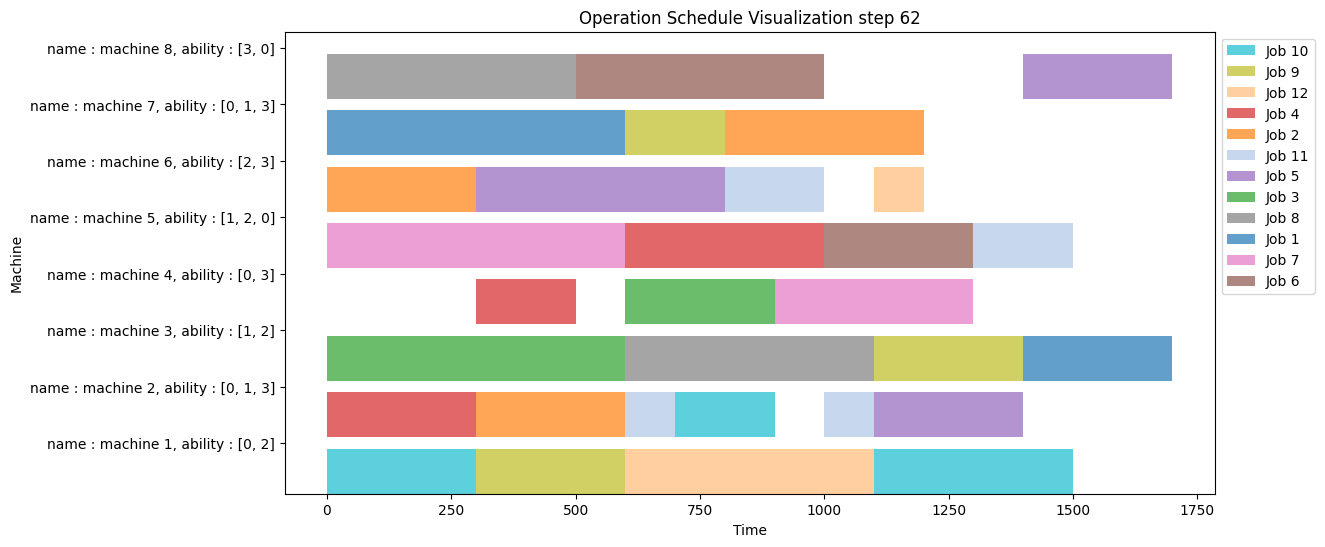

In [34]:
for env in custom_env:
    obs, info = env.reset()
    done = False
    while True:
        action, _ = model.predict(obs, deterministic = False)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("Goal reached!", "final score=", reward)
            print('finish_time', info['finish_time'])
            print('job_density', info['job_density'])
            print('machine_operation_rate', info['machine_operation_rate'])
            print('job_deadline', info['job_deadline'])
            print('job_time_exceeded', info['job_time_exceeded'])
            env.render()
            break

In [32]:
log_dir = "./logs/"
new_logger = configure(log_dir, ["tensorboard"])

# 모델 학습
model = PPO('MultiInputPolicy', env, verbose=1)
model.set_logger(new_logger)  # 새로운 로거 설정
model.learn(total_timesteps=1000000)

# 학습 완료 후 TensorBoard 실행 명령어 안내
print("Run the following command to visualize training in TensorBoard:")
print(f"tensorboard --logdir={log_dir}")

NameError: name 'configure' is not defined